# LEAD QUAL Model

Lead Qual Forecasting -- we wish to forecast incoming lead qual tickets to optimize staffing levels.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import keyring
import sqlalchemy
import cx_Oracle
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa import arima_model as am


In [2]:
filepath1 = './Train_data.csv'
filepath2 = './Test_data.csv'
def initialCSV(csv_filepath):
    dfRaw = pandas.read_csv(csv_filepath, index_col=0)
    dfRaw.index = pandas.to_datetime(dfRaw.index)
    dfRaw['Count_Tickets'] = dfRaw['Count_Tickets'].astype(float)
    return dfRaw
dfLeadsTrain = initialCSV(filepath1)
dfLeadsTest = initialCSV(filepath2)
dfLeadsTrain['Day_of_Week'] = dfLeadsTrain.index.dayofweek
dfLeadsTest['Day_of_Week'] = dfLeadsTest.index.dayofweek

In [3]:
dfLeadsTrain.head(5).T

Date,2016-05-01 00:00:00,2016-05-02 00:00:00,2016-05-03 00:00:00,2016-05-04 00:00:00,2016-05-05 00:00:00
Count_Tickets,136.0,293.0,281.0,288.0,275.0
Day_of_Week,6.0,0.0,1.0,2.0,3.0


Looking at the raw data:

In [4]:
name = 'Day_of_Week'
dummies = pandas.get_dummies(dfLeadsTrain[name], prefix = name)
cols = dummies.columns
dfLeadsTrain[cols] = dummies
testdummies = pandas.get_dummies(dfLeadsTest[name], prefix = name)
testcols = testdummies.columns
dfLeadsTest[testcols] = testdummies

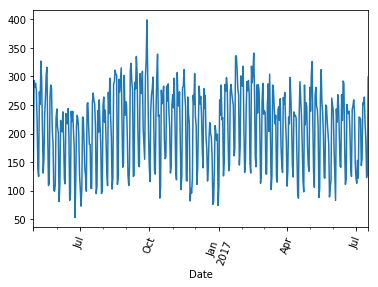

In [5]:
dfLeadsTrain.Count_Tickets.plot()
plt.xticks(rotation=70)
plt.show()

Let's also import some date information

In [6]:

dfDates = pandas.read_csv('./Date_Table.csv')
dfDates.index = dfDates.CALENDAR_DATE[:]
dfDates = dfDates.drop('CALENDAR_DATE', axis = 1)
dfLeadsTrain = dfLeadsTrain.join(dfDates)
dfLeadsTest = dfLeadsTest.join(dfDates)
dfLeadsTrain.head().T

Date,2016-05-01 00:00:00,2016-05-02 00:00:00,2016-05-03 00:00:00,2016-05-04 00:00:00,2016-05-05 00:00:00
Count_Tickets,136.0,293.0,281.0,288.0,275.0
Day_of_Week,6.0,0.0,1.0,2.0,3.0
Day_of_Week_0,0.0,1.0,0.0,0.0,0.0
Day_of_Week_1,0.0,0.0,1.0,0.0,0.0
Day_of_Week_2,0.0,0.0,0.0,1.0,0.0
Day_of_Week_3,0.0,0.0,0.0,0.0,1.0
Day_of_Week_4,0.0,0.0,0.0,0.0,0.0
Day_of_Week_5,0.0,0.0,0.0,0.0,0.0
Day_of_Week_6,1.0,0.0,0.0,0.0,0.0
MONTH_END,0.0,0.0,0.0,0.0,0.0


Durbin Watson Statistic:

In [7]:
sm.stats.durbin_watson(dfLeadsTrain.Count_Tickets)

0.10347343427801486

Plotting the Autocorrelation and Partial Autocorrelation functions:

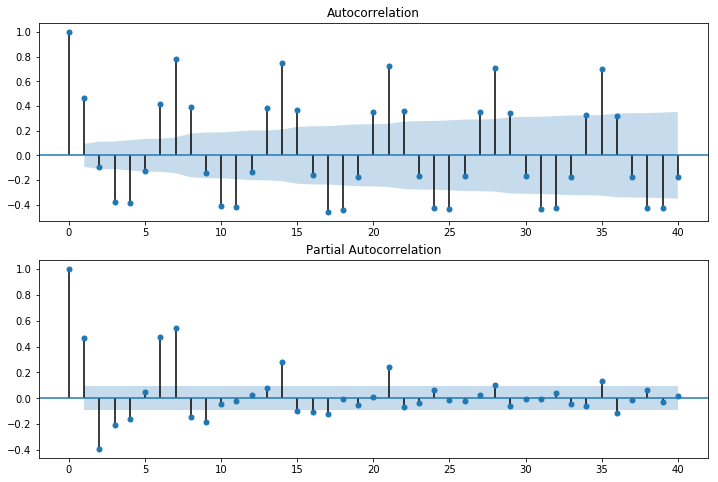

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfLeadsTrain.Count_Tickets, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfLeadsTrain.Count_Tickets, lags=40, ax=ax2)
plt.show()

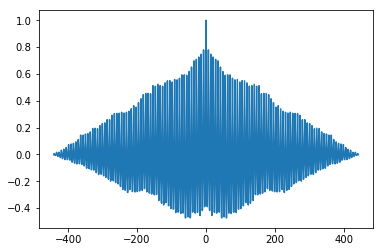

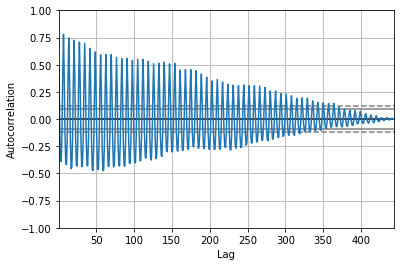

In [9]:
dfLeads2 = dfLeadsTrain[:]
col = (dfLeads2['Count_Tickets'] - dfLeads2['Count_Tickets'].mean()) / (dfLeads2['Count_Tickets'].std())
col = col.rename('Count_Tickets2')
dfLeads2 = pandas.concat([dfLeads2, col], axis =1)
plt.acorr(dfLeads2['Count_Tickets2'],maxlags = len(dfLeads2['Count_Tickets2']) -1, linestyle = "solid", usevlines = False, marker='')
plt.show()
autocorrelation_plot(dfLeadsTrain['Count_Tickets'])
plt.show()


In [10]:
print dfLeadsTrain.columns
print dfLeadsTest.tail()


Index([u'Count_Tickets', u'Day_of_Week', u'Day_of_Week_0', u'Day_of_Week_1',
       u'Day_of_Week_2', u'Day_of_Week_3', u'Day_of_Week_4', u'Day_of_Week_5',
       u'Day_of_Week_6', u'MONTH_END', u'HOLIDAY'],
      dtype='object')
            Count_Tickets  Day_of_Week  Day_of_Week_0  Day_of_Week_1  \
Date                                                                   
2017-08-04          235.0            4              0              0   
2017-08-05          103.0            5              0              0   
2017-08-06           92.0            6              0              0   
2017-08-07          305.0            0              1              0   
2017-08-08          260.0            1              0              1   

            Day_of_Week_2  Day_of_Week_3  Day_of_Week_4  Day_of_Week_5  \
Date                                                                     
2017-08-04              0              0              1              0   
2017-08-05              0              0   

In [11]:
exog_cols = [u'Day_of_Week_1',u'Day_of_Week_2', u'Day_of_Week_3', u'Day_of_Week_4', u'Day_of_Week_5',
       u'Day_of_Week_6',     u'MONTH_END', u'HOLIDAY']
modelARMA = am.ARMA(dfLeadsTrain.Count_Tickets, (2,1), exog=dfLeadsTrain[exog_cols])
resultsARMA = modelARMA.fit()
print (resultsARMA.summary())

C:\Users\nedd\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:          Count_Tickets   No. Observations:                  443
Model:                     ARMA(2, 1)   Log Likelihood               -2098.879
Method:                       css-mle   S.D. of innovations             27.612
Date:                Tue, 12 Sep 2017   AIC                           4223.758
Time:                        10:03:05   BIC                           4276.975
Sample:                    05-01-2016   HQIC                          4244.746
                         - 07-17-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 257.9823      6.477     39.830      0.000     245.288     270.677
Day_of_Week_1           0.7393      4.336      0.171      0.865      -7.759       9.237
Day_of_Week_2   

Durbin-Watson on results shows no/low positive autocorrelation

In [12]:
print resultsARMA.aic, resultsARMA.bic, resultsARMA.hqic
print sm.stats.durbin_watson(resultsARMA.resid.values)

4223.75823325 4276.97464026 4244.74631931
1.99553734717


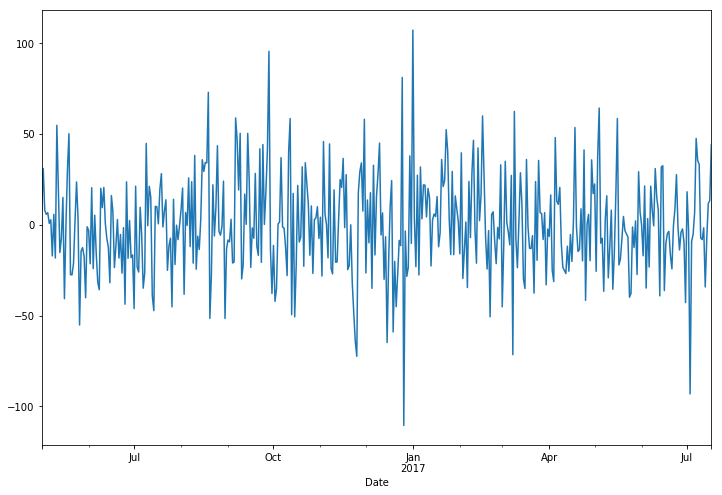

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = resultsARMA.resid.plot(ax=ax)
plt.show()

In [14]:
residARMA = resultsARMA.resid
stats.normaltest(residARMA)

NormaltestResult(statistic=11.573950993310387, pvalue=0.0030672450544859948)

Residuals display odd discontinuity

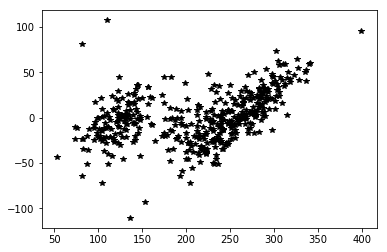

In [15]:
plt.plot(dfLeadsTrain['Count_Tickets'], residARMA, 'k*')
plt.show()

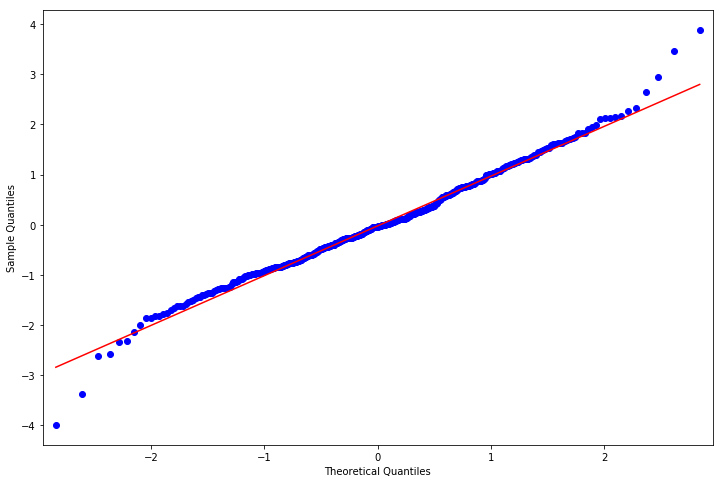

In [16]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(residARMA, line='q', ax=ax, fit=True)
plt.show()

##### Ploting the ACF and PACF for the residuals, we see strong 5 day spikes we haven't accounted for.

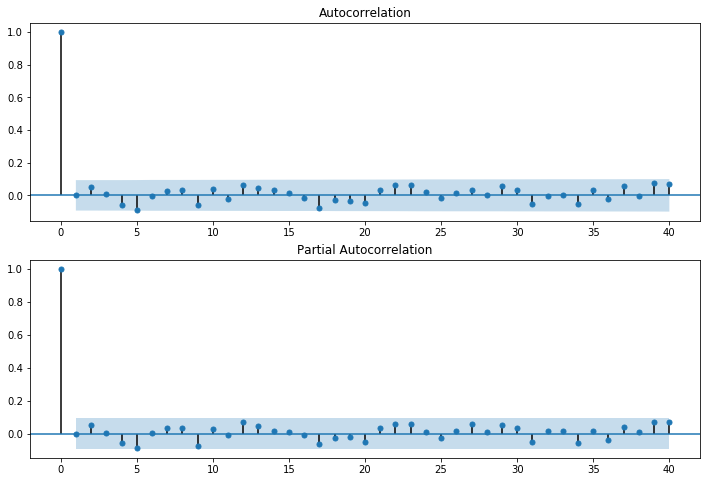

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residARMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residARMA, lags=40, ax=ax2)
plt.show()

Next, we calculate the lag, autocorrelation (AC), Q statistic and Prob>Q. 

In [18]:
r,q,p = sm.tsa.acf(residARMA.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pandas.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table)

     lag        AC          Q  Prob(>Q)
0    1.0 -0.000827   0.000305  0.986066
1    2.0  0.050693   1.149063  0.562969
2    3.0  0.005996   1.165171  0.761369
3    4.0 -0.056275   2.587255  0.629082
4    5.0 -0.087199   6.009502  0.305295
5    6.0 -0.001048   6.009997  0.422071
6    7.0  0.023782   6.265717  0.509088
7    8.0  0.035275   6.829627  0.555121
8    9.0 -0.060883   8.513340  0.483352
9   10.0  0.040365   9.255146  0.508073
10  11.0 -0.020591   9.448626  0.580555
11  12.0  0.063908  11.316698  0.501990
12  13.0  0.042472  12.143706  0.515897
13  14.0  0.030318  12.566094  0.560938
14  15.0  0.016128  12.685902  0.626544
15  16.0 -0.015412  12.795570  0.687642
16  17.0 -0.079920  15.751293  0.541529
17  18.0 -0.029195  16.146664  0.582312
18  19.0 -0.036334  16.760444  0.606093
19  20.0 -0.044076  17.665811  0.609412
20  21.0  0.031910  18.141470  0.640035
21  22.0  0.064496  20.089265  0.577456
22  23.0  0.063620  21.989035  0.520914
23  24.0  0.023026  22.238487  0.565035


We note that the p-values for the Ljung–Box Q test all are well below .05 

In [19]:
predict_leadsARMA = resultsARMA.predict(440,464, exog=dfLeadsTest[exog_cols], dynamic=True)
print predict_leadsARMA 

2017-07-15    111.309546
2017-07-16    117.422102
2017-07-17    248.694920
2017-07-18    250.053586
2017-07-19    259.114123
2017-07-20    245.357774
2017-07-21    198.091699
2017-07-22    115.632562
2017-07-23    121.241720
2017-07-24    252.252239
2017-07-25    253.373499
2017-07-26    262.212721
2017-07-27    248.249819
2017-07-28    200.790960
2017-07-29    118.151890
2017-07-30    123.593110
2017-07-31    247.214068
2017-08-01    255.421851
2017-08-02    264.124529
2017-08-03    250.034186
2017-08-04    202.456381
2017-08-05    119.706295
2017-08-06    125.043897
2017-08-07    255.800963
2017-08-08    256.685666
Freq: D, dtype: float64


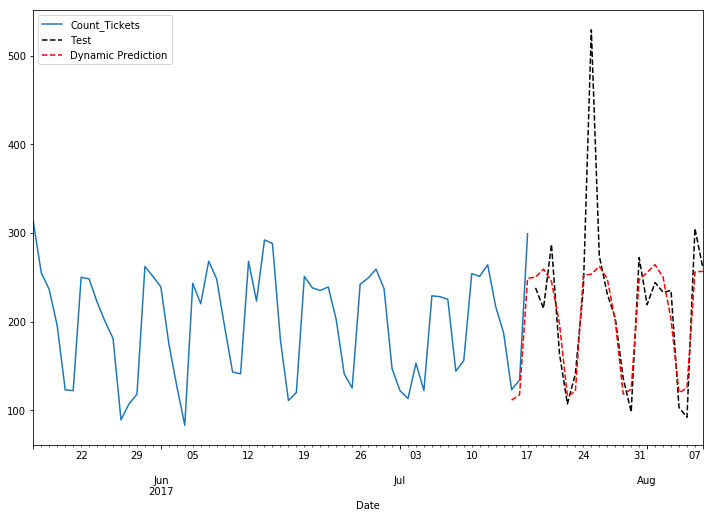

In [20]:
ax = dfLeadsTrain['Count_Tickets'].ix[380:].plot(figsize=(12,8))
ax = dfLeadsTest['Count_Tickets'].plot(ax=ax, style='k--', label='Test')
ax = predict_leadsARMA .plot(ax=ax, style='r--', label='Dynamic Prediction');
ax.legend()
plt.show()

In [21]:
sm.tools.eval_measures.rmse(predict_leadsARMA[-22:],dfLeadsTest.Count_Tickets)

64.163569342791561

In [22]:
fullpreds = resultsARMA.predict(1,len(dfLeadsTrain), exog=dfLeadsTrain[exog_cols], dynamic=False)
sm.tools.eval_measures.rmse(fullpreds, dfLeadsTrain.Count_Tickets)

66.343045040755058

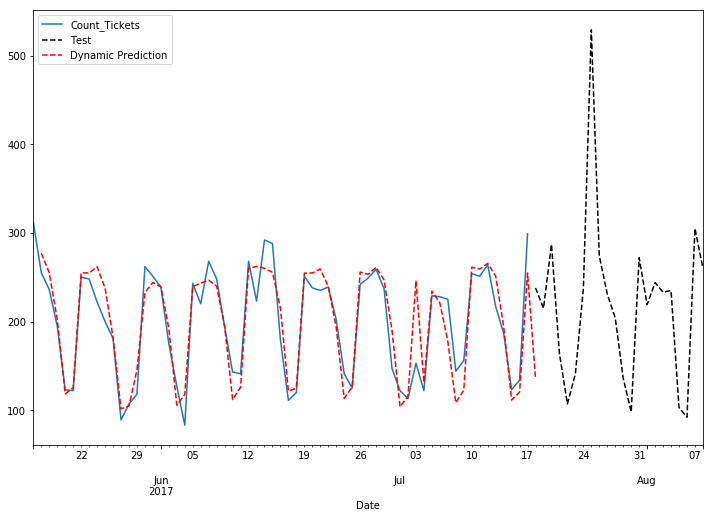

In [23]:
ax = dfLeadsTrain['Count_Tickets'].ix[380:].plot(figsize=(12,8))
ax = dfLeadsTest['Count_Tickets'].plot(ax=ax, style='k--', label='Test')
ax = fullpreds.ix[380:].plot(ax=ax, style='r--', label='Dynamic Prediction');
ax.legend()
plt.show()